x**3/3 - x**2 + 2*x

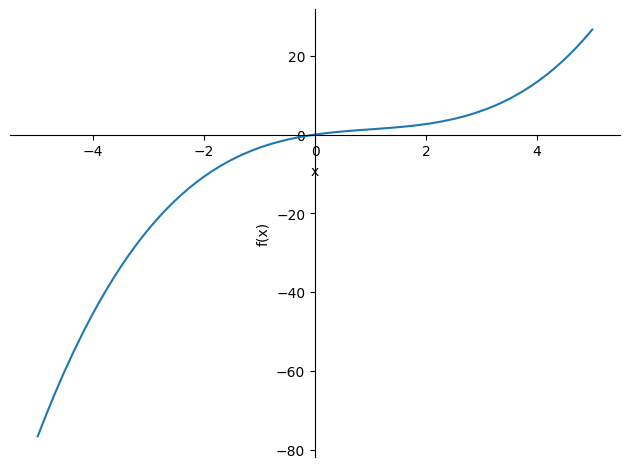

In [1]:
import numpy as np
import sympy as sp
from sympy import sympify, lambdify, symbols, integrate, Interval, Symbol, I, S, oo, plot
from IPython.display import display

# Compute integration
f = sympify("x**2-x*2+2")
#f = sympify("x*cos(x)")
x = Symbol('x')
fi = integrate(f, x)
display(fi)
plot(fi, (x, -5, 5))

# Generate data for symbolic regression
fl = lambdify((x), fi, "numpy")
xs = np.arange(-5, 5, 0.001)
ys = fl(xs)

In [2]:
# Load symbolicregression model

import torch
import os, sys
import symbolicregression
import sympytorch
import requests

model_path = "ckpt/model.pt" 
try:
    if not os.path.isfile(model_path): 
        print("Downloading model...")
        url = "https://dl.fbaipublicfiles.com/symbolicregression/model1.pt"
        r = requests.get(url, allow_redirects=True)
        open(model_path, 'wb').write(r.content)
    if not torch.cuda.is_available():
        model = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        model = torch.load(model_path)
        model = model.cuda()
    print(model.device)
    print("Model successfully loaded!")

except Exception as e:
    print("ERROR: model not loaded! path was: {}".format(model_path))
    print(e)    
    
est = symbolicregression.model.SymbolicTransformerRegressor(
                        model=model,
                        max_input_points=10001,
                        n_trees_to_refine=100,
                        rescale=True
                        )
##Example of data
xs = np.reshape(xs, (len(xs),1))
ys = np.reshape(ys, (len(ys),1))
est.fit(xs,ys)

replace_ops = {"add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/"}
model_str = est.retrieve_tree(with_infos=True)["relabed_predicted_tree"].infix()
for op,replace_op in replace_ops.items():
    model_str = model_str.replace(op,replace_op)

expr = sp.parse_expr(model_str)
display(expr)

sp.expand(expr)

/home/mcwave/anaconda3/envs/symbolic/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0
Model successfully loaded!


(5.7755748763054182e-6 - 0.81323306476822285*x_0)*(-0.92224484694313154*(0.66666650684720143*x_0 - 1)**2 - 1.53705426449183)

0.33333317500111475*x_0**3 - 1.0000021320620919*x_0**2 + 1.9999904555645421*x_0 - 1.4203866161324002e-5

In [3]:
xs.shape

(10000, 1)